# Model Building for Supervised Machine Learning

[Click here](https://neuronjolt.com/data/downloads/ch_10_model_building.ipynb) to download this chapter as a Jupyter (.ipynb) file.

This chapter explains and demonstrates how the following tasks can be structured to build a supervised machine learning model, using scikit-learn tools:

* ***Proprocessing*** - Getting the data ready for the specific machine-learning algorithms that will be tried
* ***Estimating generalization performance*** - Estimating how each machine-learning algorithm will perform on new data that was not used to train it. This is also called ***performance on out-of-sample data***
* ***Model tuning*** - Determining the best parameter setting(s) for each machine-learning algorithm

The chapter culminates with explanation and demonstration of how to accomplish both ***model tuning*** and ***estimation of generalization performance***. They can't be accomplished at the same time without biasing the estimate of generalization performance, so we will learn how to first estimate generalization performance for one or more algorithms, and then determine the best parameter settings for the model with the best estimated generalization performance.

## Module and Function Imports

In [1]:
import time
import os
import numpy as np
import pandas as pd
import mglearn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

## Load the *Titanic* Data

In this chapter we will again be using the *Titanic* data, which describes passengers on the *Titanic*. Below is a brief description of the variables:

* `Survived` - the target variable. Has values 0 or 1, with 1 representing that the passenger survived the disaster
* `SibSp` - represents number of siblings or spouse traveling with the passenger
* `Parch` - represents the number of parents or children traveling with the passenger
* `Pclass` - represents class of ticket
* `Embarked` - represents the port from which the passenger embarked.

**Note:** This is only a subset of the actual *Titanic* dataset.

In [2]:
titanic = pd.read_csv('https://neuronjolt.com/data/titanic.csv')

In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    int64  
 1   Pclass    712 non-null    int64  
 2   Sex       712 non-null    object 
 3   Age       712 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Embarked  712 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 39.1+ KB


In [4]:
features = titanic.drop(columns = 'Survived')
target = titanic['Survived']

## Estimating Generalization Performance with Cross Validation

The purpose of supervised machine learning is to build a model that can effectively predict the values of a target variable based on the values of a set of other variables called the *features*. We use labeled training data to build the model, but as we do so we want to build the model that will make the best predictions for new, unlabeled data in the future. This is called ***generalization performance*** or ***out-of-sample performance***.  

We typically estimate generalization performance by splitting our labeled data into two parts, the training set and the test set. We build the model on the training set, with no participation whatsoever from the test set, and then we pretend that the test set is new unlabeled data for which we need to make predictions. We make the predictions, and then we estimate generalization performance by comparing the predictions to the actual values of the target variable. 

To prevent our estimate of generalization performance from being overly influenced by the random features of one train-test split we typically split the data multiple times, giving us several test-set performances. The mean of several test set performance is a more reliable estimate of generalization performance than performance on a single test set. The term for this process of repeatedly dividing our data into training and test data for the purpose of estimating generalization performance is ***cross validation***. In this section we will learn about several methods for cross validation.

### K-Fold Cross Validation
K-fold cross validation is the most commonly-used form of cross validation. In k-fold cross validation the data is divided randomly into $k$ parts of approximately equal size, called *folds*. Next, a sequence of $k$ models is trained and tested, with each fold taking a turn serving as the test data. Usually the first $\frac{1}{k}$ of the data serves as the first fold, and so on.

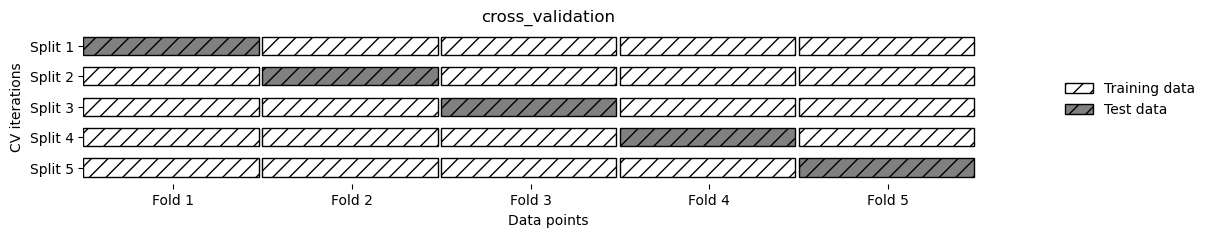

In [5]:
# Visualize 5-fold cross validation
mglearn.plots.plot_cross_validation()

K-fold cross validation uses the labeled data more efficiently than multiple random train-test splits. With K-fold cross validation each row is treated equally; each row is in the test set $k$ times and in the training set $k-1$ times. With multiple random train-test splits one row might be overrepresented in the test sets while another row is overrepresented in the training sets. 

K-fold cross validation is the default form of cross validation used by scikit-learn's `cross_validate()` function (used to estimate generalization performance) and `GridSearchCV()` function (used for model tuning with grid search, which we will see in a later section of this chapter). Those functions use K-fold cross validation when the target is numeric and stratified K-fold cross validation when the target is categorical. The term ***stratified*** means that when the data is divided into folds the function attempts to keep the ratio of values of the target class the same in each fold. For example, if we are building a model to predict whether a cell is cancerous or not and 45% of the rows overall are cancerous, the splitting procedure for stratified K-fold cross validation attempts to split the data so that the percentage of cancerous rows in each fold is as close to 45% as possible. 

### Define a splitter to use other types of cross validation

If you want to use a cross validation strategy other than K-fold or stratified K-fold, or if you want to override the default parameters for K-fold or stratified K-fold cross validation you can use a scikit-learn Splitter object to define and implement the cross validation strategy. Splitter objects implement a specific type of splitting strategy for cross validation. They are created with constructor functions similar to how estimators or transformers are created. Examples of the splitters available in scikit-learn include the following:

* **K-fold cross validation** (create with `KFold()` function) - divide the data into k folds; each fold takes a turn as the test fold, with the other folds used for training. When using the splitter object for K-fold you can instruct it to shuffle the data first. This is the default splitter for the `cross_validate()` function for regression tasks. Note that K-fold cross validation in scikit-learn doesn't shuffle the samples by default before creating the folds. This could lead to problems if the data is sorted in some systematic fashion. The `KFold()` splitter function has a `shuffle` parameter that can be set to `True` to shuffle the data before the folds are defined
* **Stratified K-fold cross validation** (create with `StratifiedKFold()` function) - like k-fold cross validation, but the splits maintain the relative proportions of the target class values in each fold. This is the default splitter for the `cross_validate()` function for classification tasks.
* **Repeated K-fold cross validation** (create with `RepeatedKFold()` function) - perform k-fold more than once, shuffling the data in between
* **Repeated Stratified K-fold cross validation** (create with `RepeatedStratifiedKFold()` function) - like repeated K-fold, but stratified
* **Leave-one-out cross validation** (create with `LeaveOneOut()` function) - each fold is a single instance
* **Shuffle-split cross validation** (create with `ShuffleSplit()` function) - like random train-test splitting, specifying either number of instances in train and test, or percentage of dataset in train and test. Use for regression tasks.
* **Stratified shuffle-split cross validation** (create with `StratifiedShuffleSplit()` function) - use for classification tasks.
* **GroupKFold** (create with `GroupKFold()` function) - takes a groups array parameter to indicate groups in the data that should not be split when creating the training and test sets. For example, if you have medical data where you have multiple samples from the same patient but want to train models to generalize to new patients you can specify the patients as groups and prevent them from being split across training and testing data. Another example would be when you are training a speech recognition model and have multiple speech recordings from the same speaker but want to train a model to recognize speech of new speakers.

Note that these splitter classes may be passed to the `cross_validate()`, or `GridSearchCV()` functions via the `cv` parameter.

### Example of K-fold cross validation

Scikit-learn provides the `cross_validate()` function to do cross validation. It uses 5-fold cross validation by default for regression tasks and stratified 5-fold cross validation by default for classification tasks. 

As an example of how to use K-fold cross validation to estimate the generalization performance of a particular model we will use the `cross_validate()` function to estimate how well a 10-nearest neighbor model performs on the *Titanic* data. The *Titanic* data has both numeric and categorical features, so we will need to min-max scale the numeric features and one-hot encode the categorical features. 

### Combining steps with a scikit-learn Pipeline

To perform the cross validation of the 10-nearest neighbor model on the *Titanic* data requires several train-test splits. The data will need to be preprocessed and the model trained and tested after every split. Scikit-learn provides a class called a `Pipeline` that we can use to combine steps such as preprocessing and estimating. A pipeline, created with the `Pipeline()` constructor function, allows us to sequentially apply a list of transformers to preprocess the data and, if desired, conclude the sequence with a estimator. All the intermediate steps of the pipeline must be be transformers, that is, they must be objects that implement `fit()` and `transform()` methods. If an estimator is added as the final step in the pipeline it only needs to implement the `fit()` method. Conveniently, if the final step of a pipeline is an estimator the pipeline itself functions as an estimator and has the usual `fit()`, `predict()` and `score()` methods. It may be used as the estimator parameter in a `cross_validate()` function or any other function that requires an estimator.

The purpose of a pipeline is to assemble several steps that can be cross-validated together. When a preprocessing step is combined with an estimator in a pipeline scikit-learn ensures that the preprocessing is done correctly; transformations such as scaling are always fit to the training data first and then used to transform both the training and test data.


In [6]:
# Create a column transformer
ct = ColumnTransformer([
    ('min_max', MinMaxScaler(), ['Age', 'SibSp', 'Parch']),
    ('one_hot', OneHotEncoder(), ['Pclass', 'Sex', 'Embarked'])
])

In [7]:
# Package the column transformer together with the 10-nn model in a pipeline

knn_pipe = Pipeline([
    ('preprocessing', ct),
    ('classification', KNeighborsClassifier(n_neighbors = 10))
])

Use the `cross_validate()` function to estimate generalization performance of the 10-nearest neighbor model on the *Titanic* data. The cross validation strategy defaults to 5-fold cross validation. A different strategy may be defined by using the `cv` parameter. When the `cv` parameter is set to an integer that integer becomes the number of folds to be used in K-fold or stratified K-fold cross validation. It may also be set to a splitter object. Below we set `cv = 10` to specify 10-fold cross validation. Stratified 10-fold cross validation will be used because the target variable is categorical.

The `cross_validate()` function returns a dictionary containing training and scoring times, the test score, and optionally the training score for each split. The dictionary returned is easily converted to a pandas DataFrame for display or analysis. 

In [8]:
scores = cross_validate(estimator = knn_pipe, 
                         X = features,
                         y = target,
                         cv = 10)

In [9]:
# View the scores dictionary
scores

{'fit_time': array([0.02058482, 0.00865412, 0.01056385, 0.00803304, 0.01152611,
        0.01197171, 0.01157713, 0.01190686, 0.01049113, 0.01280999]),
 'score_time': array([0.01402497, 0.01046562, 0.009444  , 0.00965881, 0.01450205,
        0.01428509, 0.01327801, 0.01412106, 0.01792312, 0.01491833]),
 'test_score': array([0.72222222, 0.76388889, 0.8028169 , 0.74647887, 0.84507042,
        0.74647887, 0.85915493, 0.78873239, 0.73239437, 0.88732394])}

In [10]:
# Convert the scores dictionary to a pandas DataFrame and view it
scores_df = pd.DataFrame(scores)
scores_df

fit_time  score_time  test_score
0  0.020585    0.014025    0.722222
1  0.008654    0.010466    0.763889
2  0.010564    0.009444    0.802817
3  0.008033    0.009659    0.746479
4  0.011526    0.014502    0.845070
5  0.011972    0.014285    0.746479
6  0.011577    0.013278    0.859155
7  0.011907    0.014121    0.788732
8  0.010491    0.017923    0.732394
9  0.012810    0.014918    0.887324

Note how the test score (accuracy on predictions on the test data) varies between the train-test splits. The *Titanic* data only has 712 rows, so it is a good example of a small dataset for which the mean of test performance over multiple splits should be used to estimate generalization performance.

Below we calculate the mean test score across the splits as our estimate of generalization performance of the 10-nn model on the *Titanic* data.

In [11]:
# Calculate the mean of the test_score column, which is our 
# estimate of generalization performance
scores_df['test_score'].mean()

0.7894561815336464

## Model Tuning with Grid Search 

***Model Tuning*** is the general term for the process of finding the parameter settings for the underlying prediction algorithm that result in the best generalization performance. ***Grid Search*** is one technique that may be used for model tuning. ***Grid search*** refers to the process of estimating out-of-sample performance for each parameter in a set of parameters or each parameter combination in a set of parameter combinations in order to find the parameter settings at which the model performs best on the data. Grid search uses cross validation internally. At each split of the cross validation, models using each of the parameter combinations are built on the training data and tested on the test data. In this way, each parameter combination will have several test performances which may then be averaged to obtain a robust estimate of the model's generalization performance with that particular parameter setting.

We actually performed a grid search in Chapter 7, when we generated the data for a validation curve graph for the K-nn model. We used nested looping code, with data splitting in the outer loop and training and testing for all values of $k$ in the inner loop. So, our nested looping code was performing a grid search. In this chapter we will use the scikit-learn `GridSearchCV()` function to perform grid search rather than constructing our own nested looping code. 

### For Grid Search Another Level of Splitting is Typically Added

The purpose of a grid search is to find the best parameter setting(s) for an algorithm. After the cross validation completes the mean test performance across the splits for each parameter setting is calculated. The setting with the highest mean test performance is the best parameter setting. 

It is important to note, however, that the mean test performance across the splits *should not be used as an estimate of generalization performance*. It should only be used to determine the best parameter setting(s) for the model. The reason it should not be used as an estimate of generalization performance is because the same test data is used multiple times across different hyperparameter settings. This reuse introduces bias because the model selection process implicitly tailors the hyperparameters to the test data, which likely gives performance estimates for these parameters an optimistic bias. 

To combine parameter tuning with estimation of generalization performance another data split is added. The data is first split into **training data** and **test data**. The training data is used for parameter tuning and the test data is used to estimate generalization performance. As part of the parameter tuning process the **training data** from the first split gets repeatedly split into **training data** and **validation data** as part of the cross validation process for each combination of parameters. Once the best parameter combination is found we then train the model with the best parameters on all the training data from the original split, then run it on the test data from the original split to estimate its generalization performance. This process bases the estimate of generalization performance on just one train-test split. This is not necessarily a problem if you have a large amount of data, but it is best practice to base estimates of generalization performance on multiple train-test splits, so the single outer split may be replaced by a cross validation process. This is called ***nested cross validation*** because both the outer split and the inner model tuning process utilize cross validation.

### Visualization of Grid Search with Cross Validation Process Applied to Training Data

Image source: Scikit-learn User's Guide at [https://scikit-learn.org/dev/modules/cross_validation.html](https://scikit-learn.org/dev/modules/cross_validation.html)

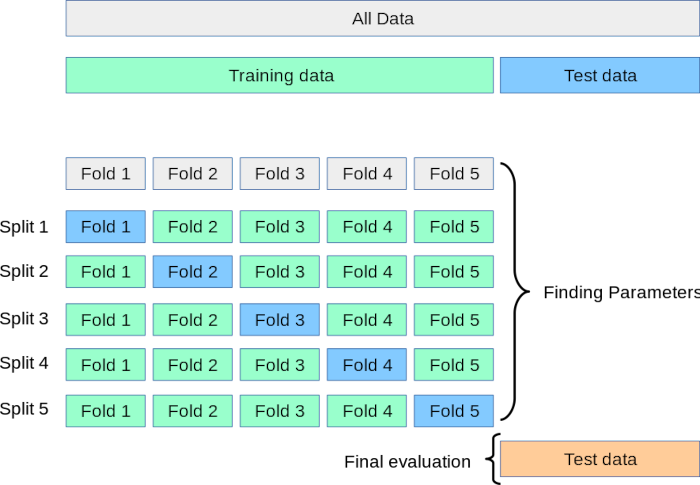

## Grid Search to Tune a Logistic Regression Model on the *Titanic* Data

In this section we will do a train-test split of the *Titanic* data, conduct a grid search on the training data with a logistic regression algorithm, and then use the fitted grid search object to score the model on the test data. This score is our estimate of generalization performance. We will then re-run the grid search on ALL the data to tune the model. This process is a full model building process that can work well if you have a lot of data. If you don't have a lot of data this process is not recommended because it bases its estimate of generalization performance on just one train-test split.

Logistic regression is a form of linear regression that is used to make predictions when the target is categorical. It has a parameter, `C`, that controls the model's flexibility to fit the training data. The higher `C` is, the more flexible the model is to fit the training data. We will use the `GridSearchCV()` function to create the GridSearch object.

### Split the *Titanic* data into training and test sets

Split the Titanic data into training and test sets. Use a stratified split, and set random_state to 102 so that the results are repeatable.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    stratify = target,
                                                    random_state = 102)

### Create a pipeline

In the code cells below we create a column transformer for the *Titanic* data and then package the column transformer together with the logistic regression estimator in a pipeline.

In [13]:
ct = ColumnTransformer([
    ('std_scale', StandardScaler(), ['Age', 'SibSp', 'Parch']),
    ('one_hot', OneHotEncoder(handle_unknown = 'ignore'), ['Sex', 'Pclass', 'Embarked'])
])

In [14]:
pipe = Pipeline([
    ('pre', ct),
    ('cls', LogisticRegression(max_iter = 2_000))
])

### Specify the parameter values to try

The pipeline we created can serve as the estimator in the `GridSearchCV()` function because its last step is an estimator. When we specify the values of parameter `C` that we want to try we need to specify them in a way that provides the information needed to pass the parameters to the correct step of the pipeline. To do so, we need to specify the parameters in a dictionary and use the following convention for the key value in the dictionary:  

> the step in the pipeline, followed by two underscores, followed by the parameter name.

The parameter `C` is the parameter for logistic regression that influences the model's flexibility to fit the training data. The higher `C` is the more flexible the model is to fit the training data. It should be varied on a logarithmic scale.

Below we set up a parameter grid to test various settings of the C parameter, generating the values on a logarithmic scale between $10^{-4}$ and $10^4$, or between 0.0001 and 10,000.

In [15]:
pgrid = {
    'cls__C': np.logspace(-4, 4, 12)
}

### Instantiate the `GridSearchCV` class

Specify the estimator, the parameter grid to search, and the cross validation strategy. The cross validation will be performed for every parameter combination from the parameter grid. Here we use 6-fold cross validation.

In [16]:
grid_search = GridSearchCV(estimator = pipe,
                           param_grid = pgrid,
                           cv = 6)

### Fit the grid search to the training data

The `fit()` method of `GridSearchCV` finds the best parameters through a cross validation process in which at each split a model is built and tested for every value of the parameter setting. The best parameter setting is the one that has the highest mean performance on the test folds. After the best parameter setting is identified the grid search automatically fits a model with the best parameter settings to the whole training set. The fitted `GridSearchCV` object is thus itself an estimator, with `fit()`, `predict()`, and `score()` methods.

In [17]:
grid_search.fit(features, target)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('std_scale',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch']),
                                                                        ('one_hot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Sex',
                                                                          'Pclass',
                                                                          'Embarked'])])),
                                       ('cls',
                                        LogisticRegression(max_iter=2000))]),
             param_grid={'cls__C': array([1.00000000e-04, 5.33669923e-04, 2.84803587e-03, 1.51991108e-02,
       8.11130831e-02, 4.32876128e-01, 2.31012970e+00, 1.23284674e+01,
       6.57933225e+01, 3.51119173e+02, 1.87381742e+03, 1.00000000e+04])})

### View the best parameter setting

It is important to check the best parameter setting after the grid search and compare it to the range of values you specified for the parameter. If the best parameter setting is at or very near the ends of the ranges of values you specified in your parameter grid for the grid search you should widen the parameter grid and re-run the grid search.

Conversely, if the best parameter setting is in the middle of the range of values you specified for your parameter grid you might want to narrow the range and re-run the grid search.

In [18]:
# Best parameter setting from the grid search
grid_search.best_params_

{'cls__C': 0.43287612810830617}

### Score the grid search on the test data

This is the test data from the original train-test split. The training data from the original split was used in the grid search to find the best parameter setting. Now we can use the test data to estimate the model's generalization performance, since it wasn't used to set the parameters.

In [19]:
grid_search.score(X_test, y_test)

0.8089887640449438

### Perform a second grid search on all the data to tune the model

The grid search performed to get the best parameter settings to build the model used to estimate generalization performance ran on only the training data. For the final tuning of the model we re-run the grid search on all the data. After this grid search object is fit to all the data it may be used as an estimator to make predictions for future data.

In [20]:
grid_search.fit(features, target)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('std_scale',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch']),
                                                                        ('one_hot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Sex',
                                                                          'Pclass',
                                                                          'Embarked'])])),
                                       ('cls',
                                        LogisticRegression(max_iter=2000))]),
             param_grid={'cls__C': array([1.00000000e-04, 5.33669923e-04, 2.84803587e-03, 1.51991108e-02,
       8.11130831e-02, 4.32876128e-01, 2.31012970e+00, 1.23284674e+01,
       6.57933225e+01, 3.51119173e+02, 1.87381742e+03, 1.00000000e+04])})

In [21]:
grid_search.best_params_

{'cls__C': 0.43287612810830617}

### Viewing the results of the grid search's cross validations

A `GridSearchCV` object also has the attribute `cv_results_`, which may be used to access results of the grid search. 

In [22]:
# Detailed results from the grid search
grid_search.cv_results_

{'mean_fit_time': array([0.01207062, 0.00938626, 0.01032118, 0.0098327 , 0.01006043,
        0.01054919, 0.01048632, 0.01117365, 0.01077914, 0.01084268,
        0.01108535, 0.01133466]),
 'std_fit_time': array([0.00307816, 0.00013351, 0.00116747, 0.00018731, 0.0005826 ,
        0.00057695, 0.00063618, 0.00135458, 0.00023718, 0.00017945,
        0.00101426, 0.00108021]),
 'mean_score_time': array([0.00488655, 0.00480088, 0.00487975, 0.00464042, 0.00493574,
        0.00494858, 0.00447313, 0.00465985, 0.00439926, 0.00446435,
        0.00444631, 0.00497937]),
 'std_score_time': array([0.00086881, 0.00040769, 0.00059314, 0.00070354, 0.00020291,
        0.00091869, 0.00018339, 0.00042222, 0.00017049, 0.00025195,
        0.00011084, 0.0010067 ]),
 'param_cls__C': masked_array(data=[0.0001, 0.0005336699231206312, 0.002848035868435802,
                    0.01519911082952933, 0.08111308307896872,
                    0.43287612810830617, 2.310129700083158,
                    12.32846739442066, 

#### Putting the results into a DataFrame
The grid search object's `cv_results_` attribute is a dictionary, so it can be easily converted to a pandas dataframe for viewing and analysis.

In [23]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.012071      0.003078         0.004887        0.000869   
1        0.009386      0.000134         0.004801        0.000408   
2        0.010321      0.001167         0.004880        0.000593   
3        0.009833      0.000187         0.004640        0.000704   
4        0.010060      0.000583         0.004936        0.000203   
5        0.010549      0.000577         0.004949        0.000919   
6        0.010486      0.000636         0.004473        0.000183   
7        0.011174      0.001355         0.004660        0.000422   
8        0.010779      0.000237         0.004399        0.000170   
9        0.010843      0.000179         0.004464        0.000252   
10       0.011085      0.001014         0.004446        0.000111   
11       0.011335      0.001080         0.004979        0.001007   

    param_cls__C                             params  split0_test_score  \
0       0.000100                 {'cls__C': 0.0001}           0.596639   
1       0.000534  {'cls__C': 0.0005336699231206312}           0.596639   
2       0.002848   {'cls__C': 0.002848035868435802}           0.638655   
3       0.015199    {'cls__C': 0.01519911082952933}           0.773109   
4       0.081113    {'cls__C': 0.08111308307896872}           0.747899   
5       0.432876    {'cls__C': 0.43287612810830617}           0.747899   
6       2.310130      {'cls__C': 2.310129700083158}           0.739496   
7      12.328467      {'cls__C': 12.32846739442066}           0.739496   
8      65.793322      {'cls__C': 65.79332246575683}           0.739496   
9     351.119173     {'cls__C': 351.11917342151344}           0.739496   
10   1873.817423     {'cls__C': 1873.8174228603868}           0.739496   
11  10000.000000                {'cls__C': 10000.0}           0.739496   

    split1_test_score  split2_test_score  split3_test_score  \
0            0.596639           0.596639           0.596639   
1            0.596639           0.596639           0.596639   
2            0.630252           0.638655           0.613445   
3            0.815126           0.798319           0.823529   
4            0.806723           0.798319           0.823529   
5            0.789916           0.781513           0.831933   
6            0.789916           0.756303           0.823529   
7            0.789916           0.756303           0.823529   
8            0.789916           0.756303           0.823529   
9            0.789916           0.756303           0.823529   
10           0.789916           0.756303           0.823529   
11           0.789916           0.756303           0.823529   

    split4_test_score  split5_test_score  mean_test_score  std_test_score  \
0            0.593220           0.593220         0.595499        0.001611   
1            0.593220           0.593220         0.595499        0.001611   
2            0.618644           0.694915         0.639095        0.026679   
3            0.771186           0.822034         0.800551        0.021688   
4            0.788136           0.847458         0.802011        0.030781   
5            0.805085           0.855932         0.802046        0.034897   
6            0.796610           0.855932         0.793631        0.038992   
7            0.796610           0.855932         0.793631        0.038992   
8            0.796610           0.855932         0.793631        0.038992   
9            0.796610           0.855932         0.793631        0.038992   
10           0.796610           0.855932         0.793631        0.038992   
11           0.796610           0.855932         0.793631        0.038992   

    rank_test_score  
0                11  
1                11  
2                10  
3                 3  
4                 2  
5                 1  
6                 4  
7                 4  
8                 4  
9                 4  
10                4  
11                4

### A note on parallelization of cross validation and grid search

When you think about what cross validation and grid search are actually doing you should understand that they are doing many many independent runs of models. Since these runs are independent they are great candidates for parallelization over multiple cores of a CPU or multiple machines in a cluster. The `cross_validate()` function and the `GridSearchCV()` function both have a `n_jobs` parameter that can be used to specify how many CPU cores to use. The default is 1. The code in the cell below shows how to determine how many CPU cores your computer has.

In [24]:
# See how many cores are on your system
print(os.cpu_count())

4


**Note:** If you set `n_jobs = -1` it will use all the CPU cores on your computer.

## Nested Cross Validation

So far we have only used one outer split into **training** and **test** sets, so our estimate of generalization performance is based on just one hold-out dataset. 

A more sophisticated way of estimating generalization performance is **nested cross validation**, which uses multiple splits into **training** and **test** sets.

* Outer loop runs over splits of the data into **training** and **test** sets.
* Inner loop runs grid search on the training set, breaking it repeatedly into **training** and **validation** sets, and then scores the best model from the grid search on the test set.

The result of the nested cross validation procedure is a list of test set scores that give us an idea how the model generalizes. Since each outer loop split can result in different best parameters on the inner cross validation this procedure is *NOT* used to find best parameters, or to find a model to use on new data. Rather, it is used to investigate which model performs best on a particular dataset. After that is determined you can then do an un-nested grid search on the best model to find the best parameter combinations for that model.

**Nested cross validation is implemented in scikit-learn by running `cross_validate()` with an instance of `GridSearchCV()` as the estimator.**

Below we perform a separate nested cross validation for each model (K-nn and logistic regression). Because K-nn and logistic regression require different preprocessing and have different hyperparameters we set up separate column transformers, pipelines, parameter grids, and grid searches for each algorithm. To practice using a custom cross validation strategy we use a splitter object to set up repeated stratified K-fold cross validation. Specifically, we will use 3 x stratified 6-fold cross validation for both the inner and outer cross validations. Finally, we also specify the scoring metric. The metric we are specifying, accuracy, is the default for classification tasks, so we don't really need to set it here. We do so, however, to learn how to set the performance metric in case we want to use more sophisticated performance metrics in the future.

### Compare generalization performance of Logistic Regression and K-nn with nested cross validation

The code cells below set up the nested cross validation by creating the column transformers, pipelines, parameter grids, cross validation splitter, variable to hold the performance metric, and grid search objects.

In [25]:
# Make column transformers for each model

ct_lreg = ColumnTransformer([
    ('std_scale', StandardScaler(), ['Age', 'SibSp', 'Parch']),
    ('one_hot', OneHotEncoder(handle_unknown = 'ignore'), ['Sex', 'Pclass', 'Embarked'])
])

ct_knn = ColumnTransformer([
    ('mm_scale', MinMaxScaler(), ['Age', 'SibSp', 'Parch']),
    ('one_hot', OneHotEncoder(handle_unknown = 'ignore'), ['Sex', 'Pclass', 'Embarked'])
])

In [26]:
# Make separate pipelines for each model

pipe_lreg = Pipeline([
    ('preprocessing', ct_lreg),
    ('classifier', LogisticRegression(max_iter = 2_000))
])

pipe_knn = Pipeline([
    ('preprocessing', ct_knn),
    ('classifier', KNeighborsClassifier())
])

In [27]:
# Define parameter grids for each model

pgrid_lreg = {'classifier__C': np.logspace(-4, 4, 15)}

pgrid_knn = {'classifier__n_neighbors': np.arange(15, 46, 2)}

In [28]:
# Set up a splitter for 3 x stratified 6-fold cv

rskf_3x6f = RepeatedStratifiedKFold(n_splits = 6, n_repeats = 3)

In [29]:
# Set the scoring metric

scoring = 'accuracy'

In [30]:
# Define grid search for each model

gs_lreg = GridSearchCV(estimator = pipe_lreg, 
                       param_grid = pgrid_lreg, 
                       cv = rskf_3x6f, 
                       n_jobs = -1, 
                       scoring = scoring)

gs_knn = GridSearchCV(estimator = pipe_knn, 
                      param_grid = pgrid_knn, 
                      cv = rskf_3x6f, 
                      n_jobs = -1, 
                      scoring = scoring)

Once the grid search objects are created we can perform nested cross validation by using the grid search object as the estimator within a `cross_validate()` function. Timers have been added to the code, using the `perf_counter()` function from the `time` module.

In [31]:
# Start the timer
start = time.perf_counter()

# Perform the nested cross validation for logistic regression
lreg_gen_scores = cross_validate(estimator = gs_lreg, 
                                 X = features, 
                                 y = target,
                                 cv = rskf_3x6f,
                                 scoring = scoring)
# Stop the timer
end = time.perf_counter()

# Print out message with the elapsed time
print(f"Elapsed time is {end - start:0.2f} seconds")

Elapsed time is 45.29 seconds


In [32]:
# Start the timer
start = time.perf_counter()

# Perform the nested cross validation for K-nn
knn_gen_scores = cross_validate(estimator = gs_knn, 
                                X = features, 
                                y = target,
                                cv = rskf_3x6f,
                                scoring = scoring)

# Stop the timer
end = time.perf_counter()

# Print message with the elapsed time
print(f"Elapsed time is {end - start:0.2f} seconds")

/Users/mhaney/miniconda3/envs/ba2/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Elapsed time is 58.48 seconds


In [33]:
print(f"lreg mean test score: {np.mean(lreg_gen_scores['test_score'])}")
print(f"lreg std test score: {np.std(lreg_gen_scores['test_score'])}")

lreg mean test score: 0.7921473674215449
lreg std test score: 0.026035103222871888


In [34]:
print(f"knn mean test score: {np.mean(knn_gen_scores['test_score'])}")
print(f"knn std test score: {np.std(knn_gen_scores['test_score'])}")

knn mean test score: 0.7897656237636297
knn std test score: 0.026188206170252717


### Perform grid search on model with best estimated generalization performance to set parameters

To identify the model with the best estimated generalization performance we need to consider both the mean performance and standard deviation of performance from the nested cross validation. We should also consider factors such as the model comprehensibility and model speed. 

These models have very similar performance, but the logistic regression model had slightly higher mean accuracy and similar standard deviation of accuracy. We will move forward with the logistic regression model. Because the performance of the two models is so similar you may see a different result if you re-run this code.

The final step in our model building process is to run a new grid search for the best model using all our labeled data. When it finishes the grid search will retrain the model with the best parameters on all the labeled data, and it will then function as an estimator that we can use to make predictions for other *Titanic* passengers.

In [35]:
gs_lreg.fit(features, target)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=6, random_state=None),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('std_scale',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch']),
                                                                        ('one_hot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Sex',
                                                                          'Pclass',
                                                                          'Embarked'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=2000))]),
             n_jobs=-1,
             param_grid={'classifier__C': array([1.00000000e-04, 3.72759372e-04, 1.38949549e-03, 5.17947468e-03,
       1.93069773e-02, 7.19685673e-02, 2.68269580e-01, 1.00000000e+00,
       3.72759372e+00, 1.38949549e+01, 5.17947468e+01, 1.93069773e+02,
       7.19685673e+02, 2.68269580e+03, 1.00000000e+04])},
             scoring='accuracy')

In [36]:
gs_lreg.best_params_

{'classifier__C': 0.019306977288832496}

**Now we can use `gs_lreg` as our final model to make predictions on new data**